# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [783]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [784]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [785]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [786]:
def denormalize_image(image):
    return (image + 1) / 2

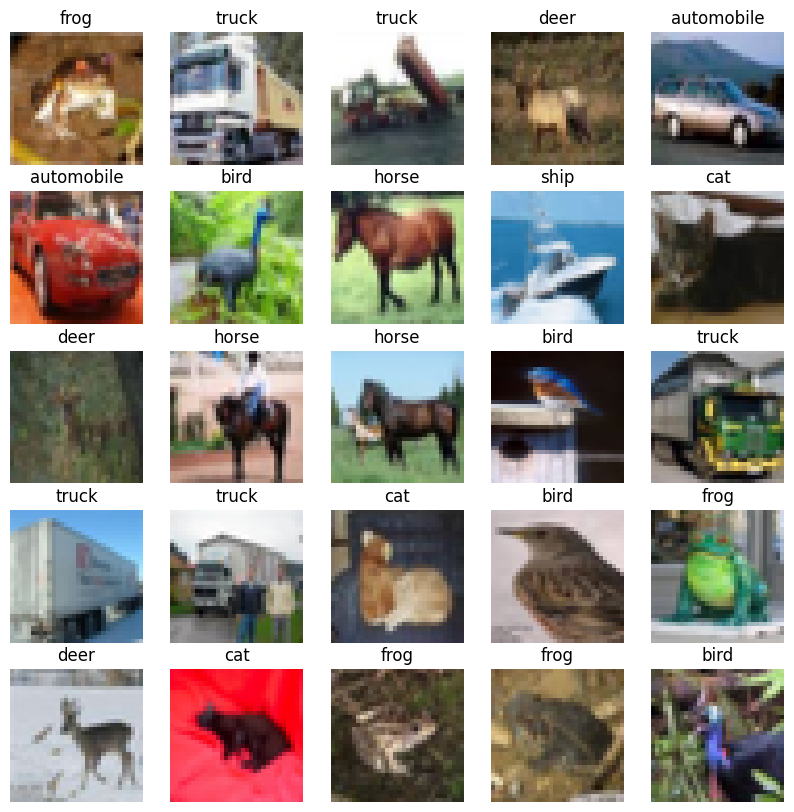

In [787]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [788]:
image.shape

torch.Size([3, 32, 32])

In [789]:
from torch.utils.data import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

len(train_loader), len(val_loader)

(196, 79)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [790]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 128, 4, stride=2, padding=1),            # [N, 12, 16, 16]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(128, 256, 4, stride=2, padding=1),           # [N, 24, 8, 8]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.Conv2d(256, 256, 4, stride=2, padding=1),           # [N, 48, 4, 4]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.Conv2d(256, 256, 4, stride=2, padding=1),           # [N, 96, 2, 2]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.Conv2d(256, 256, 4, stride=2, padding=1),           # [N, 256, 1, 1]
        # )
        
        hid = 16
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16 * hid, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16 * hid),
            
            nn.Conv2d(16 * hid, 4 * hid, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4 * hid),
            
            nn.Conv2d(4 * hid, 2 * hid, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hid),
            
            # nn.Conv2d(hid, hid, 3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),
            # nn.BatchNorm2d(hid),
            
            nn.Conv2d(2 * hid, hid, 3, padding=1),
        )
        
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        
        x = self.encoder(x)
        x = x.reshape(-1, 256)
        return x
        
        ### END SOLUTION

In [791]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
# assert encoder(noise).view(-1).shape < 1*3*32*32
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [792]:
encoder(noise).shape

torch.Size([1, 256])

In [793]:
noise = torch.rand(1, 3, 32, 32) - 1
print(noise.shape)
emb = noise.reshape(-1)
print(emb.shape)
emb = emb.reshape(-1, 3, 32, 32)
print(emb.shape)

torch.allclose(noise, emb)

torch.Size([1, 3, 32, 32])
torch.Size([3072])
torch.Size([1, 3, 32, 32])


True

In [794]:
noise = torch.rand(1, 3, 32, 32)
print(noise.shape)
noise = torch.rand(1, 3, 32, 32)
print(noise.shape)


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [795]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # [N, 48, 4, 4]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # [N, 48, 4, 4]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # [N, 24, 8, 8]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256),
        #     nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [N, 12, 16, 16]
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),   # [N, 3, 32, 32]
        #     nn.Sigmoid(),
        # )
        
        hid = 16
        
        self.decoder = nn.Sequential(     
            # nn.Upsample(scale_factor=2),
            
            nn.Conv2d(hid, 2 * hid, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(2 * hid),
            
            nn.Conv2d(2 * hid, 4 * hid, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(4 * hid),
            
            nn.Conv2d(4 * hid, 16 * hid, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(16 * hid),
            
            # nn.Conv2d(hid, hid, 3, padding=1),
            # nn.ReLU(),
            # nn.Upsample(scale_factor=2),
            # nn.BatchNorm2d(hid),
            
            nn.Conv2d(16 * hid, 3, 3, padding=1),
            nn.Sigmoid(),
        )       
        
        
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        
        x = x.reshape(-1, 16, 4, 4)
        x = self.decoder(x)
        # x = torch.sigmoid(x)
        return x
        
        ### END SOLUTION

In [796]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

In [797]:
encoder(noise).shape, decoder(emb).shape

(torch.Size([1, 256]), torch.Size([1, 3, 32, 32]))

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [798]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [799]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0977            4.33m
         2           1.9481            4.27m
         3           1.8222            4.17m
         4           1.7255            4.09m
         5           1.6332            3.97m
         6           1.5533            3.87m
         7           1.4854            3.78m
         8           1.4195            3.70m
         9           1.3587            3.60m
        10           1.3044            3.53m
        20           0.9331            2.60m
        30           0.7183            1.72m
        40           0.5899           51.79s
        50           0.4984            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.393

In [800]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [801]:
encoder.to(device)
decoder.to(device);

In [802]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [803]:
### BEGIN SOLUTION
criterion = nn.MSELoss()
### END SOLUTION

In [804]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        
        optim.zero_grad()
        image = image.to(device)
        
        out = encoder(image)
        out = decoder(out)
        
        loss = F.mse_loss(out, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        
        ### END SOLUTION
    return sum(losses) / len(losses)

In [805]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/196 [00:00<?, ?it/s]

0.1913418460409252

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [806]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        
        image = image.to(device)
        
        with torch.no_grad():
            out = encoder(image)
            out = decoder(out)
            loss = F.mse_loss(out, image)
            
        losses.append(loss.item())
        
        ### END SOLUTION
    return sum(losses) / len(losses)

In [807]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/79 [00:00<?, ?it/s]

0.16824791646456416

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [808]:
def full_train(device, train_loader, val_loader):
    ### BEGIN SOLUTION
    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load('model/encoder.pt'))
    decoder.load_state_dict(torch.load('model/decoder.pt'))
    return encoder, decoder
    
    ### END SOLUTION
    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params, lr=0.001)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()
    return encoder, decoder

In [809]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [810]:
# torch.save(encoder.state_dict(), 'model/encoder.pt')
# torch.save(decoder.state_dict(), 'model/decoder.pt')

In [811]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0873            4.12m
         2           1.9391            4.04m
         3           1.8147            3.94m
         4           1.7163            3.86m
         5           1.6276            3.77m
         6           1.5486            3.69m
         7           1.4802            3.61m
         8           1.4170            3.53m
         9           1.3601            3.45m
        10           1.3090            3.37m
        20           0.9347            2.53m
        30           0.7140            1.69m
        40           0.5669           51.00s
        50           0.4664            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.4101

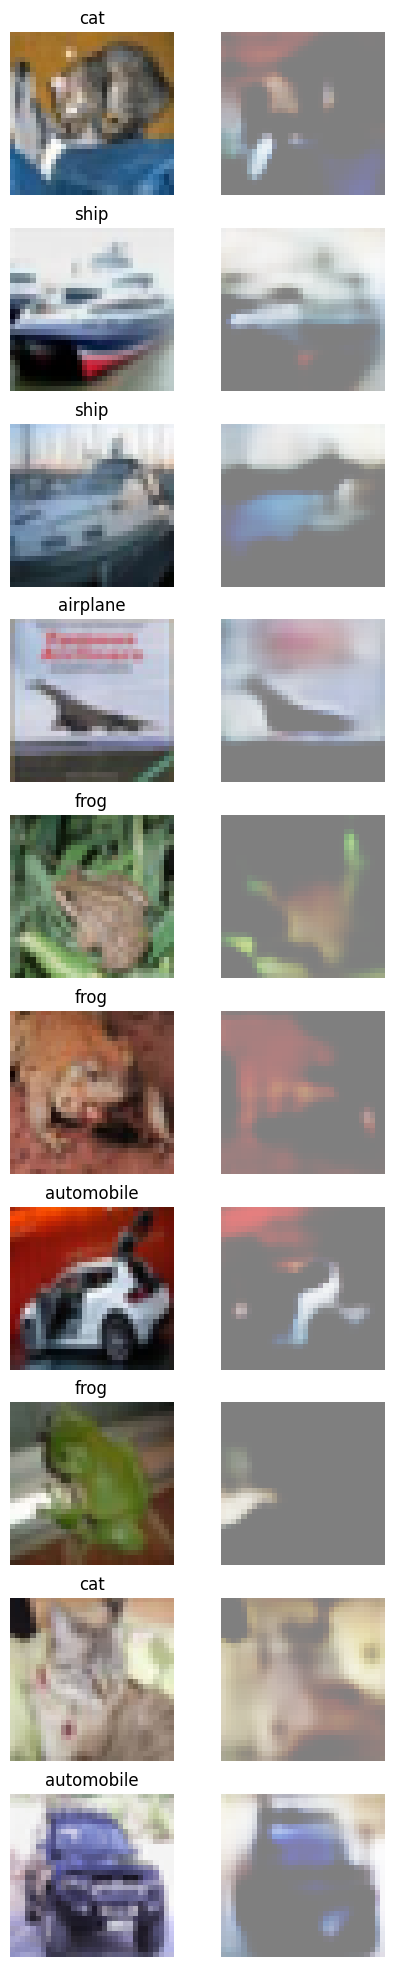

In [812]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
# for index, (image, label) in enumerate(val_loader):
for index, (image, label) in enumerate(DataLoader(val_dataset, batch_size=1, shuffle=False)):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [813]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    
    encoder.eval()
    with torch.no_grad():
        for batch_img, batch_lbl in tqdm(dataloader):
            # print(batch_img.shape)
            # break
            for emb, label in zip(encoder(batch_img.to(device)), batch_lbl):
                # print(encoder(batch_img.to(device)).shape)
                # break
                representations[label.item()].append(emb.detach().ravel())
            # break
    return representations
    
    ### END SOLUTION

In [814]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

  0%|          | 0/79 [00:00<?, ?it/s]

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [815]:
def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    
    from scipy.linalg import sqrtm
    
    mr = repr1.mean(0)
    mg = repr2.mean(0)
    
    sr = np.cov(repr1, rowvar=False)
    sg = np.cov(repr2, rowvar=False)
    
    return np.sum((mr - mg) ** 2) + np.trace(sr + sg - 2 * sqrtm(sr @ sg))
    
    ### END SOLUTION

In [816]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

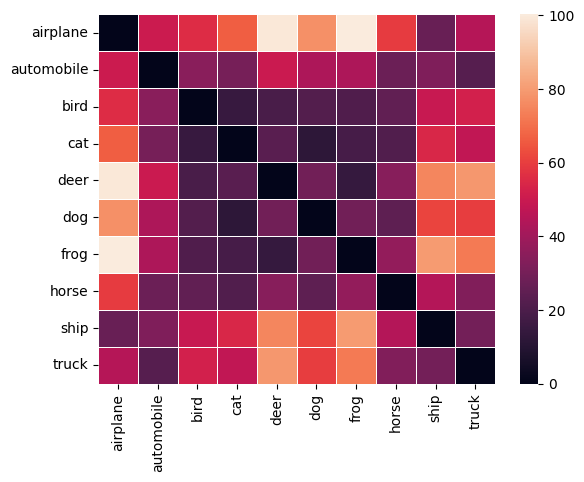

In [817]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

In [818]:
# YOUR CODE HERE

1. Посчитал FID для кошек и собак из CIFAR10, но не связанных с обучением АЕ. 
2. Посчитал FID для кошек и собак из <a href="https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset?select=kagglecatsanddogs_3367a">вот этого датасета с Kaggle</a>.

1.

In [819]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)

len(train_dataset)

Files already downloaded and verified


10000

In [820]:
torch.manual_seed(1)
cats_dogs_dataset = torch.utils.data.ConcatDataset([
    torch.utils.data.Subset(train_dataset, [i for i in torch.randperm(len(train_dataset))[:10000] if train_dataset[i][1] == 3][:500]), 
    torch.utils.data.Subset(train_dataset, [i for i in torch.randperm(len(train_dataset))[:10000] if train_dataset[i][1] == 5][:500]),
])

assert len(cats_dogs_dataset) == 1000

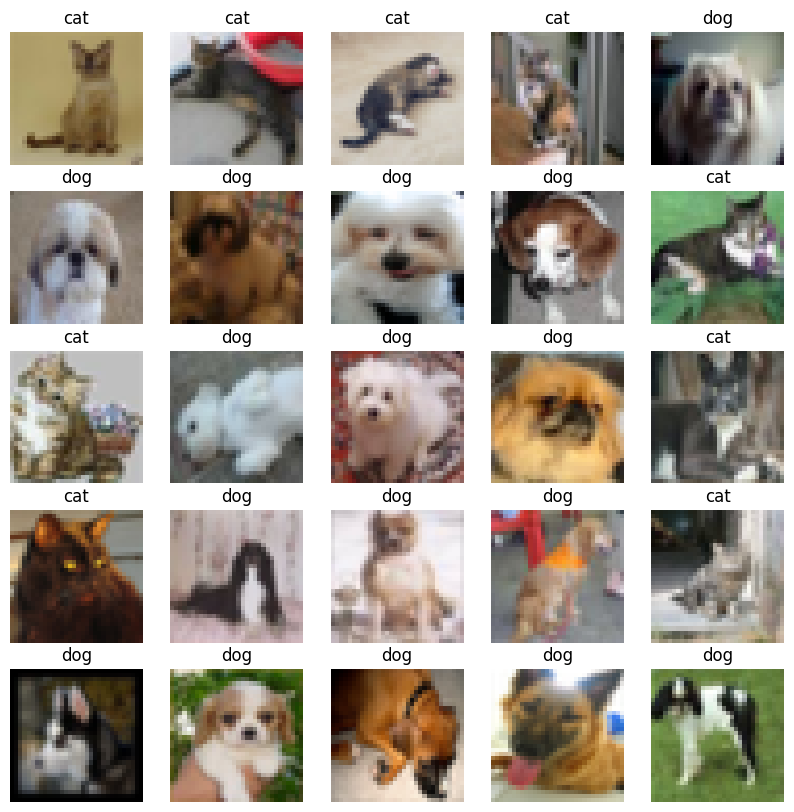

In [821]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(DataLoader(cats_dogs_dataset, batch_size=1, shuffle=True)):
    image = image[0]
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

In [822]:
representations = get_representations(DataLoader(cats_dogs_dataset, batch_size=1, shuffle=False), encoder, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [823]:
fid = calculate_fid(
            torch.stack(representations[3], dim=0).cpu().numpy(),
            torch.stack(representations[5], dim=0).cpu().numpy()
        )
fid

17.467347471401965

2.

In [824]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    lambda x: (x * 2) - 1
])

In [825]:
from skimage import io

class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, path='./data/', transform=None):
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = '{}{}/{}.jpg'.format(self.path, 'Cat' if idx < 500 else 'Dog', idx % 500)
        image = io.imread(img_name)[..., :3]

        if self.transform:
            image = self.transform(image)

        return image, 3 if idx < 500 else 5

In [826]:
cats_dogs_dataset_2 = CatDogDataset(transform=transform)

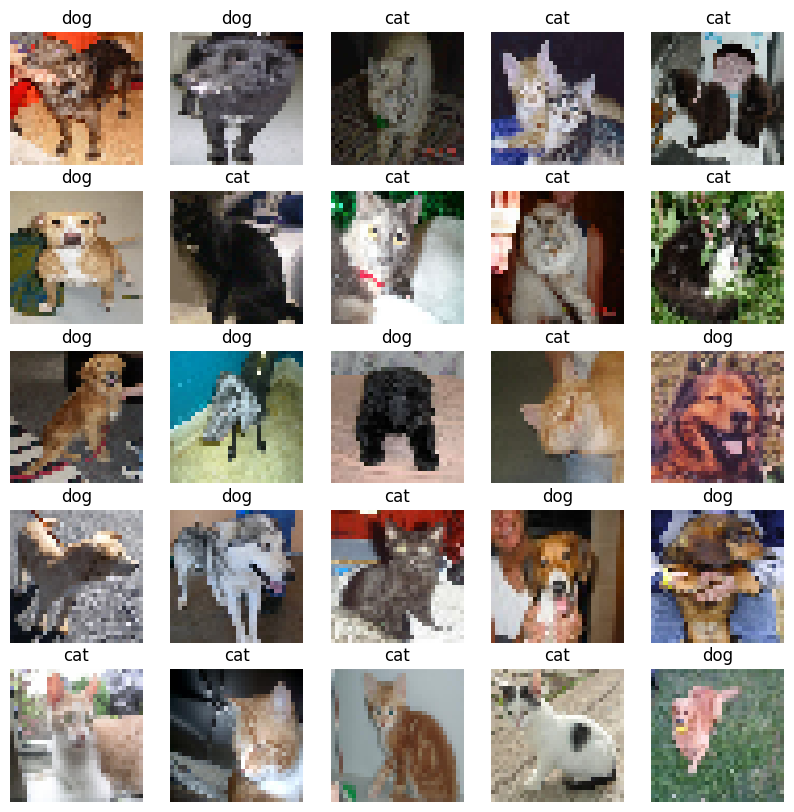

In [827]:
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(DataLoader(cats_dogs_dataset_2, batch_size=1, shuffle=True)):
    image = image[0]
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

In [828]:
representations = get_representations(DataLoader(cats_dogs_dataset_2, batch_size=1, shuffle=False), encoder, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [829]:
fid = calculate_fid(
            torch.stack(representations[3], dim=0).cpu().numpy(),
            torch.stack(representations[5], dim=0).cpu().numpy()
        )
fid

15.817753002655763

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

In [830]:
# YOUR CODE HERE

1. Сжатие картинки 32х32 (1024 пикселя) до вектора размера 256, кажется, не очень сильное, при этом  
classification_score после обучения автоэнкодера вырос с 0.31 до 0.35 (позже заменил stride=2 на макспулинги, вырос с 0.39 до 0.41), кажется, что можно было чуть больше.  
Хочется ещё больше поиграться с архитектурой автоэнкодера.  
Может быть, во всём виноват градиентный бустинг, и нужно его пробовать улучшать/менять

2. Были вот такие мысли. Если мы хотим, чтобы латентные представления картинок содержали в себе информацию о классах, то можно эту информацию там каким-то образом зашить.  
Например, можно в латентное представление добавить вектор `[0...010...0]` с единицей в позиции соответствующего класса, декодеру эту информацию можно кормить через линейный слой.
А можно кормить метку энкодеру, и посмотреть, поможет ли это разделить классы в латентном представлении

3. А может, для генерации похожих картинок сами метки и не очень нужны, но можно попробовать нагенерировать каких-нибудь признаков картинки.  
например, можно обучить классификатор, взять из него несколько первых свёрточных слоёв, заморозить им веса и потом использовать как первые слои энкодера

4. Есть идея штрафовать сеть за слишком похожие латентные представления для картинок с разными метками/признаками.  
Звучит волшебно, но пока не было идей, как это можно реализовать

![title](meme.png)